In [12]:
!pip install numpy nltk gensim pandas bertopic sentence-transformers  wordcloud

In [17]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Load dataset
df = pd.read_csv('lemmatized_transcriptions_nostopwords.csv')

# Verify columns
print("Available columns:", df.columns.tolist())
if 'Transcription' not in df.columns or 'Episode Number' not in df.columns:
    raise ValueError("Expected columns 'Transcription' and 'Episode Number' not found.")

# Prepare the transcription texts Lemmatizatied
docs = df['Lemmatized_Transcription_Normal'].astype(str).tolist()
print("First episode:", df['Episode Number'].iloc[0])

# Create vectorizer without specifying stop_words
vectorizer_model = CountVectorizer()

# Initialize BERTopic with multilingual model and custom vectorizer
topic_model = BERTopic(
    embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
    vectorizer_model=vectorizer_model
)


Available columns: ['Episode Number', 'Chunk Number', 'Duration (seconds)', 'Transcription', 'transcription', 'Unnamed: 5', 'Segmented_Transcription', 'Split_Sentences', 'Lemmatized_Transcription', 'Lemmatized_Transcription_Normal']
First episode: 1


In [18]:
# Fit model
topics, probs = topic_model.fit_transform(docs)

In [15]:
#save bertopic model
# topic_model.save("sample_data/bertopic_model")

In [25]:
#load saved bert model
# topic_model = BERTopic.load("sample_data/bertopic_model")

In [19]:
df['topic'] = topics
df['topic_probability'] = probs
df[['Episode Number', 'topic', 'topic_probability']]


,Episode Number,topic,topic_probability
0,1,0,1.0
1,1,0,1.0
2,1,0,1.0
3,1,0,1.0
4,1,0,1.0
...,...,...,...
946,59,0,1.0
947,59,0,1.0
948,59,0,1.0
949,59,0,1.0


In [20]:
# list every topic title
topic_titles = topic_model.get_topic_info()['Name'].tolist()
#save topics titles in a cvs
pd.DataFrame(topic_titles).to_csv("sample_data/bertopic_topic_titles_new.csv", index=False)
print(topic_titles)

['0_ra_gora_ta_ko', '1_gora_go_ra_ta']


In [ ]:
# save dataframe
# df.to_csv("sample_data/bertopic_output_new.csv", index=False)

In [21]:
df.shape

(951, 12)

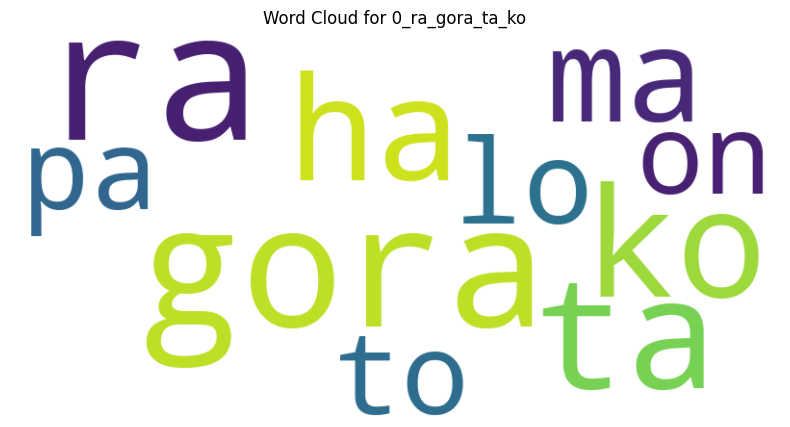

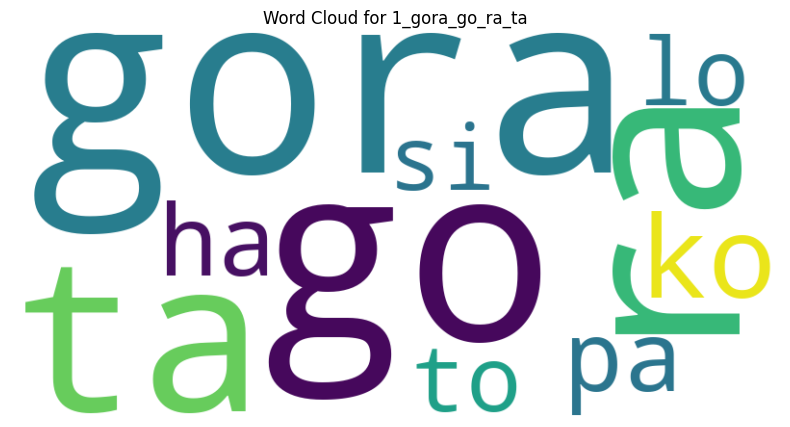

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get detailed topic information
topic_info = topic_model.get_topic_info()
topic_freq = topic_model.get_topic_freq()

# Create a mapping from topic ID to topic name/label
topic_names = dict(zip(topic_freq['Topic'], topic_info['Name']))

# Generate word clouds for each topic (excluding -1, the outlier cluster)
for topic_id in topic_freq['Topic']:
    if topic_id == -1:
        continue  # Skip outliers

    # Get top words and their weights for this topic
    topic_words = topic_model.get_topic(topic_id)
    word_weights = {word: weight for word, weight in topic_words}

    # Create and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {topic_names.get(topic_id, f'Topic {topic_id}')}")
    plt.show()


In [23]:
topic_model.get_topic_info()
topic_info.to_csv("sample_data/bertopic_topic_summary_new.csv", index=False)

In [26]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Tokenize Sesotho transcriptions
tokenized_docs = [word_tokenize(doc.lower()) for doc in docs]

# Build a dictionary and corpus for Gensim
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

# Extract BERTopic keywords only
bertopic_topics = topic_model.get_topics()
bertopic_words = [[word for word, _ in topic_model.get_topic(topic_id)] for topic_id in bertopic_topics if topic_id != -1]

# Coherence: UMass and NPMI
coherence_umass = CoherenceModel(topics=bertopic_words, texts=tokenized_docs, dictionary=dictionary, coherence='u_mass')
coherence_npmi = CoherenceModel(topics=bertopic_words, texts=tokenized_docs, dictionary=dictionary, coherence='c_npmi')

print("BERTopic Coherence (UMass):", coherence_umass.get_coherence())
print("BERTopic Coherence (NPMI):", coherence_npmi.get_coherence())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


BERTopic Coherence (UMass): -0.755646925534285
BERTopic Coherence (NPMI): -0.022019242311687122
